# Image Classification - Hristo Hristov

## Introduction
My personal challenge will be to make an A.I. model that can do landscapes calssifcation. The 6 landscapes include: buildings, forests, glaciers, mountains, seas and streets. I will be doing this project according to the IBM A.I. Project Methodology.


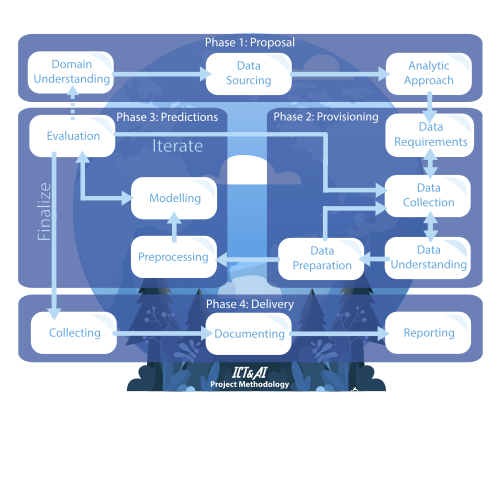

# Phase 1 - Proposal

## 1.1 Domain understanding


## 1.2 Data sourcing
I will be sourcing my data from a already made dataset from the website keggle. The dataset can be found here: 
https://www.kaggle.com/datasets/puneet6060/intel-image-classification

## 1.3 Analytic approach
### Before we start diving into the data we must first ask ourselves some main research questions, which we will have to answer here in this notebook. 
1. Is our data clean? How do we make sure it is ?
2. Is the class distribution in our data optimal?
2. Which model fits our data best for accurate predictions?

# Phase 2 - Provisioning

## 2.1 Data requirements
Since we will be working with images we do not have a lot of data requirements, however they are all as equaly as important to make sure that our model can use the data. Our requirments are:
- Images must be in a png or jpg format
- Images must not be corrupted
- Images must containt one of the 6 target classes that we have chosen
- Images must be properly sorted in a correctly named folder that coresponds to the images that it contains. (E.g., folder named building must contain buildings)

## Importing needed libraries

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from PIL import Image

## 2.2 Data collection + 2.4 Data preparation
We are going to make a method that will load our data from our train and test folders into 4 different variables. While we are looping through the images in the folders we will also do a little bit of pre-prossessing, such as : checking if the selected file is an actual valid image, changing the color of the image into RGB and resizing the images. Here we will also answer our question 1. Since the dataset of images that we have is already clean. We will make a check using a .verify() method that will see if the image is first of all an actual image and not a different type of file and second of all to make sure that it is not corruputed.

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# Make our image a standerdize size of 150x150
IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    
    datasets = ['data/seg_train/seg_train', 'data/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                try:
                    img = Image.open(img_path) # open the image file
                    img.verify() # verify that it is, in fact an image and it is not corrupted
                    
                    # Open and resize the img
                    image = cv2.imread(img_path)
                    #Change the color of the image into RGB (some images may not be in RGB)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #Resize all of our images into a small 150x150 size so that we have a quicker processing
                    image = cv2.resize(image, IMAGE_SIZE) 
                
                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
                    
                except (IOError, SyntaxError) as e:
                    print('Bad file:', img_path) # print out the names of corrupt files
                
                
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

### Here we can see that our method detects the invalid files that are in the datasets.

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/seg_train/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2192/2192 [00:02<00:00, 743.92it/s]


Bad file: data/seg_train/seg_train\buildings\decoy.txt


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:03<00:00, 768.19it/s]


Loading data/seg_test/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 765.76it/s]


## 2.3 Data Understanding
### Let's start understanind our data by plotting the class distribution in our train and test and answering the 2nd question. 2A: We can see that there is already a pretty good and even distribution between the classes in our train and test data, meaning that we will not need to reshuffle our data.

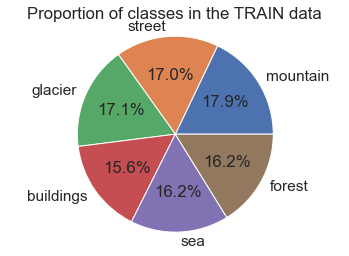

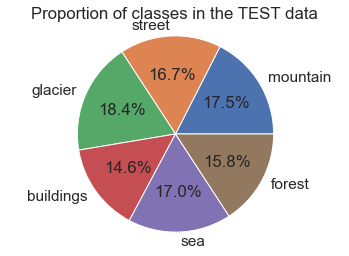

In [5]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of classes in the TRAIN data')
plt.show()


plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of classes in the TEST data')
plt.show()

### A: When we compare our train dataset to our test dataset we can see that the data is evenly distributed between all of our classes, thus there is no need for us to reshuffle our data.

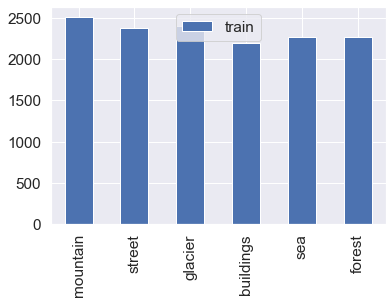

In [6]:
pd.DataFrame({'train': train_counts,
                    }, 
             index=class_names
            ).plot.bar()
plt.show()

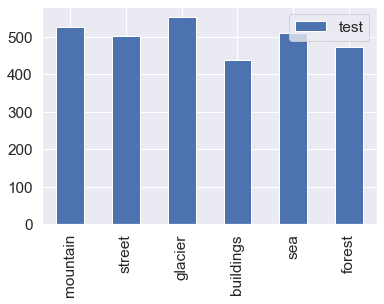

In [7]:
pd.DataFrame({'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Let's actually see some examples of our images by printing out 25 random images from out train dataset with the corresponding label

In [8]:
def display_examples(class_names, images, labels):
 
 # Display 25 random images from the dataset
  
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

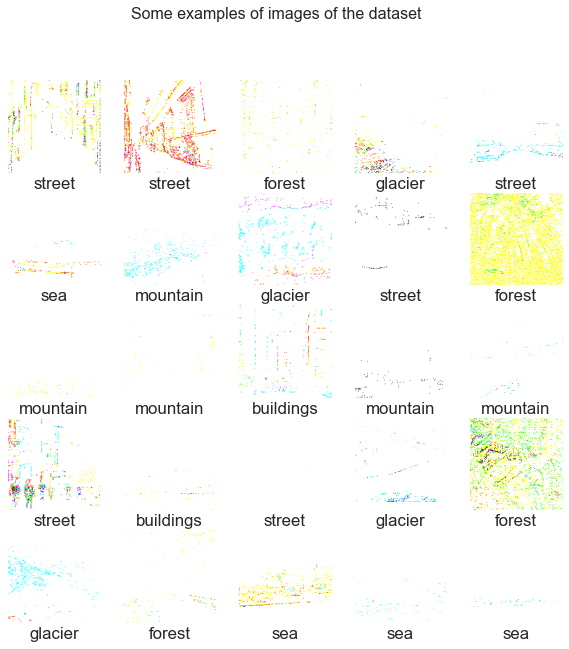

In [9]:
display_examples(class_names, train_images, train_labels)

## 2.4 Data preparation 
### We are going to scale our images again due to the reason that we have over 4000 images and we will need our model to process them in a reasonable amount of time. Also in our particular case (landscape classification) we are not interested in any particular object in the images, we are not doing any object detection.

In [10]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Phase 3 - Prediction

# 3.2 Modeling

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [12]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

### We are going to use 2 callback methods when fitting our data. One that will stop running our epoch after it detects that we are overfitting our data and the second to tell us how much time it takes for each epoch to run.


In [13]:
import time

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor = 'accuracy',mode = 'min',patience = 5,restore_best_weights=True,verbose=1)

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.perf_counter() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

### Our model was struggling to achive high accuracy due to a couple of reasons: 
- Incorrect ephocs defined, making the data overfitted
- Layer tweaks were needed

Sources: https://datascience.stackexchange.com/questions/57171/how-to-improve-low-accuracy-keras-model-design

### For further improvments we will need to do some hyperparamter tuning
- https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53

Epoch 1/5
878/878 [==============================] - 185s 210ms/step - loss: 0.8763 - accuracy: 0.6709
Epoch 2/5
878/878 [==============================] - 178s 202ms/step - loss: 0.5310 - accuracy: 0.8065
Epoch 3/5
878/878 [==============================] - 179s 204ms/step - loss: 0.3051 - accuracy: 0.8950
Epoch 4/5
878/878 [==============================] - 178s 203ms/step - loss: 0.1640 - accuracy: 0.9428
Epoch 5/5
878/878 [==============================] - 178s 202ms/step - loss: 0.0972 - accuracy: 0.9672


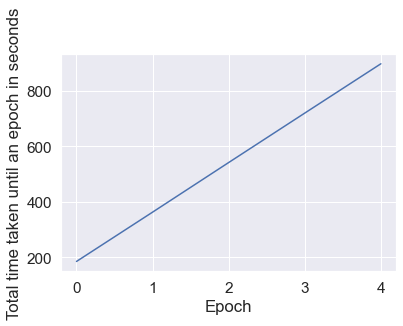

In [14]:
timeittakes = timecallback()
prediction = model.fit(train_images, train_labels, batch_size=16, epochs=5, callbacks = [timeittakes,earlystopping])

## 3.3 Evaluation

In [15]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.title("train_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.title("train_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

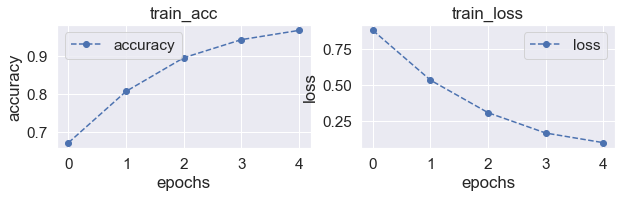

In [16]:
plot_accuracy_loss(prediction)

In [17]:
evaluation = model.evaluate(test_images, test_labels)

94/94 [==============================] - 9s 96ms/step - loss: 0.9960 - accuracy: 0.7637


In [18]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

94/94 [==============================] - 9s 97ms/step


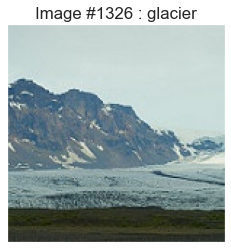

In [19]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

### Let's print out 25 random images that have been mislabeled by our model

In [20]:
def display_badexamples(class_names, images, labels,pred):
 
 # Display 25 random images from the dataset
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[pred[index]])
    plt.show()

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    
        #Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
        
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    display_badexamples(class_names,  mislabeled_images,test_labels, mislabeled_labels)

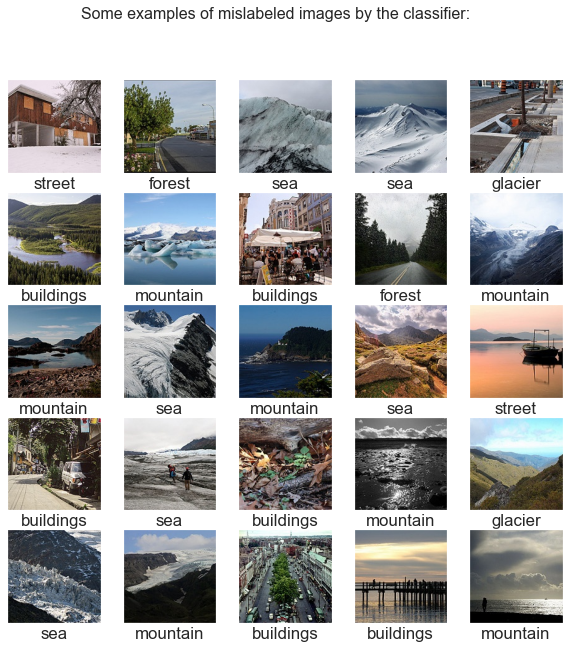

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

### By using confusion matrix we can see what our model is struggeling with. Street - buildings, glacier - mountain and sea - mountain are the pairs that our model has trouble differentiating between 

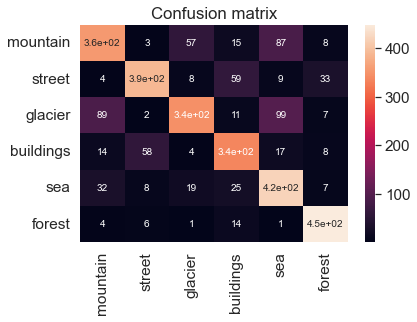

In [23]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## 3.2 Modeling - Looping back
Now that we have tried our keras model, let's try to see how a SVM model will perform.

In [2]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

flat_data_arr=[] #input array
target_arr=[] #output array
datadir='data/seg_SVMtrain/seg_SVMtrain' 

#path which contains all the categories of images
for i in os.listdir(datadir):
    
    print(f'loading... category : {i}')
    for img in tqdm(os.listdir(os.path.join(datadir, i))):
        try:
            img_path = os.path.join(os.path.join(datadir, i), img)       
            img = Image.open(img_path) # open the image file
            img.verify() # verify that it is, in fact an image
            img_array=imread(img_path)
            img_resized=resize(img_array,(150,150,3))
            flat_data_arr.append(img_resized.flatten())
            target_arr.append(os.listdir(datadir).index(i))
                    
        except (IOError, SyntaxError) as e:
            print('Bad file:', img_path) # print out the names of corrupt files
    print(f'loaded category:{i} successfully')        
            
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
   
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

loading... category : buildings


100%|███████████████████████████████████████████████████████████████████████████████| 456/456 [00:03<00:00, 120.61it/s]


Bad file: data/seg_SVMtrain/seg_SVMtrain\buildings\decoy.txt
loaded category:buildings successfully
loading... category : forest


100%|███████████████████████████████████████████████████████████████████████████████| 527/527 [00:04<00:00, 128.27it/s]


loaded category:forest successfully
loading... category : glacier


100%|███████████████████████████████████████████████████████████████████████████████| 444/444 [00:03<00:00, 129.63it/s]


loaded category:glacier successfully
loading... category : mountain


100%|███████████████████████████████████████████████████████████████████████████████| 536/536 [00:04<00:00, 130.99it/s]


loaded category:mountain successfully
loading... category : sea


100%|███████████████████████████████████████████████████████████████████████████████| 402/402 [00:03<00:00, 131.85it/s]


loaded category:sea successfully
loading... category : street


100%|███████████████████████████████████████████████████████████████████████████████| 422/422 [00:03<00:00, 128.41it/s]


loaded category:street successfully


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)
print('Splitted Successfully')


Splitted Successfully


In [5]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,67490,67491,67492,67493,67494,67495,67496,67497,67498,67499
599,0.501961,0.517647,0.552941,0.376471,0.396078,0.419608,0.564706,0.576471,0.596078,0.658824,...,4.980392e-01,0.572549,0.380392,0.360784,0.317647,0.172549,0.141176,3.921569e-01,2.862745e-01,2.588235e-01
1518,0.905882,0.941176,0.960784,0.901961,0.937255,0.956863,0.901961,0.937255,0.956863,0.901961,...,2.666667e-01,0.345098,0.392157,0.298039,0.313725,0.360784,0.282353,3.058824e-01,3.568627e-01,2.862745e-01
2746,0.807843,0.847059,0.854902,0.592157,0.631373,0.627451,0.537255,0.580392,0.549020,0.219608,...,3.176471e-01,0.294118,0.298039,0.313725,0.294118,0.298039,0.313725,2.901961e-01,2.941176e-01,3.098039e-01
100,0.164706,0.533333,0.745098,0.149020,0.545098,0.764706,0.152941,0.549020,0.752941,0.200000,...,4.705882e-02,0.090196,0.129412,0.035294,0.090196,0.129412,0.031373,8.627451e-02,1.372549e-01,3.529412e-02
315,0.219608,0.172549,0.219608,0.200000,0.160784,0.203922,0.180392,0.141176,0.184314,0.313725,...,3.568627e-01,0.572549,0.427451,0.356863,0.572549,0.427451,0.364706,5.686275e-01,4.235294e-01,3.607843e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.239216,0.533333,0.788235,0.172549,0.466667,0.721569,0.109804,0.415686,0.674510,0.098039,...,2.666667e-01,0.223529,0.235294,0.294118,0.321569,0.329412,0.388235,3.215686e-01,3.294118e-01,3.882353e-01
1095,0.756863,0.803922,0.858824,0.760784,0.796078,0.862745,0.752941,0.784314,0.858824,0.737255,...,8.980392e-01,0.843137,0.882353,0.980392,0.572549,0.611765,0.717647,3.529412e-01,3.882353e-01,5.019608e-01
1130,0.482353,0.498039,0.509804,0.482353,0.498039,0.509804,0.486275,0.501961,0.513725,0.490196,...,6.745098e-01,0.741176,0.733333,0.686275,0.717647,0.709804,0.662745,7.529412e-01,7.450980e-01,6.980392e-01
1294,0.239216,0.380392,0.521569,0.207843,0.356863,0.501961,0.215686,0.368627,0.521569,0.172549,...,6.666667e-01,0.611765,0.658824,0.643137,0.600000,0.647059,0.631373,6.235294e-01,6.705882e-01,6.549020e-01


In [6]:
y_train

599     1
1518    3
2746    5
100     0
315     0
       ..
1638    3
1095    2
1130    2
1294    2
860     1
Name: Target, Length: 2228, dtype: int32

In [4]:
x_train = x_train / 255.0 

In [17]:
from sklearn.svm import SVC # SVC is for classification, an SVR for regression exists as well.
model = SVC(C = 1,gamma = 'scale',kernel = 'poly')

In [18]:
model.fit(x_train,y_train)
print('The Model is trained well with the given images')

The Model is trained well with the given images


In [19]:
y_pred=model.predict(x_test)

In [20]:
from sklearn.metrics import accuracy_score
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The model is 34.587813620071685% accurate


In [21]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid={'C':[0.1,1],'gamma':['scale','auto'],'kernel':['rbf','poly']}
svc=svm.SVC(probability=False)
model=GridSearchCV(svc,param_grid)

In [22]:
model.fit(x_train,y_train)
print('The Model is trained well with the given images')
#model.best_params_ contains the best parameters obtained from GridSearchCV

The Model is trained well with the given images


In [23]:
model.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [24]:
y_pred=model.predict(x_test)

In [25]:
from sklearn.metrics import accuracy_score
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The model is 16.845878136200717% accurate
